# Create Random Forest Model for Predicting Landslide Probabilities

## Package Import, Working Directory and Functions

In [1]:
# import packages
import itertools
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import Window
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


In [ ]:
# TODO: set working directory
work_dir = "/local/path/to/GEO403_landslide_susceptibility_analysis"
os.chdir(work_dir)

In [3]:
def load_raster(file_path, target_nodata=-9999):
    """
    Load raster data.
    Args:
        file_path (str): Path to file
        target_nodata (int): Value to set NaN to
    Returns: 
        data (np.array): Raster data
        transform (Affine): Transformation
        crs (CRS): Coordinate Reference System
    """ 
    with rasterio.open(file_path) as src:
        data = src.read(1)
        transform = src.transform
        crs = src.crs
        nodata = src.nodatavals[0]

        # convert to float32 if target_nodata is negative
        if target_nodata < 0:
            data = data.astype(np.float32)

        # replace nodata values
        if nodata is not None:
            data[data == nodata] = target_nodata

        return data, transform, crs


def classify_lsm(lsm_raster, si_min_possible, si_max_possible):
    """
    Classifies LSM raster based on min and max possible SI values.
    Args:
        lsm_raster (np.array): Calculated LSM raster
        si_min_possible (float): Lowest possible SI value
        si_max_possible (float): Highest possible SI value
    Returns:
        classified_lsm (np.array): Classified LSM raster
    """
    # compute 1% step size
    si_range = si_max_possible - si_min_possible
    si_step = si_range / 100

    # convert LSM values to percentage scale
    si_percent = (lsm_raster - si_min_possible) / si_step  

    # define fixed classification bins based on absolute % scale (6 = very low, 1 = extreme high)
    bins = [0, 20, 40, 60, 80, 97, 100]
    labels = [6, 5, 4, 3, 2, 1]

    # apply classification
    classified_indices = np.digitize(si_percent, bins, right=True)

    # ensure indices are within the valid range (subtract 1 for zero-based indexing)
    classified_lsm = np.where(
        np.isnan(si_percent),
        np.nan,
        np.array(labels)[np.clip(classified_indices - 1, 0, len(labels) - 1)]
    )
    
    return classified_lsm

## Model Initialization, Training, Optimization and Evaluation

### Prepare Training/Test Data

In [4]:
# load categorized rasters from .pkl file
with open("created/categorized_rasters.pkl", "rb") as src:
    categorized_rasters = pickle.load(src)

# load landslides raster
landslides, transform, crs = load_raster("created/aligned_rasters/landslides.tif")

# load viewmask raster
view_mask_rast, transform, crs = load_raster("created/aligned_rasters/view_mask.tif")
view_mask = view_mask_rast > 0

# load non-categorized rasters
slope, tansform, crs = load_raster("created/aligned_rasters/slope.tif")
dem, transform, crs = load_raster("created/dem.tif")
precipitation, transform, crs = load_raster("created/aligned_rasters/precipitation.tif")

# replace categorized with continuous rasters
rasters_mixed = categorized_rasters.copy()
rasters_mixed["slope"] = slope
rasters_mixed["dem"] = dem
rasters_mixed["precipitation"] = precipitation

# define rasters as copy of categorized_rasters
rasters = rasters_mixed.copy()

In [5]:
# print shape, min and max values of mixed_rasters
for key in rasters_mixed.keys():
    print(key, rasters_mixed[key].shape, np.nanmin(rasters_mixed[key]), np.nanmax(rasters_mixed[key]))

slope (4838, 5486) 0.0 67.50209
aspect (4838, 5486) -9999 8
dem (4838, 5486) -9999.0 2602.5715
twi (4838, 5486) -9999 4
water (4838, 5486) -9999 3
precipitation (4838, 5486) 2138.412 4114.898
litho (4838, 5486) -9999.0 6.0
landcover (4838, 5486) -9999.0 9.0
road_distance (4838, 5486) -9999.0 4.0
soil (4838, 5486) -9999.0 11.0


In [6]:
# apply viewmask (mixed_rasters will stay unmasked to be used later)
for key in rasters.keys():
    rasters[key] = np.where(view_mask, rasters[key], -9999)

In [7]:
# choose training samples
positive_indices = np.where(landslides == 1)
negative_indices = np.where((landslides == -9999.0) & view_mask)

# sample negative indices to balance dataset with 
# positive samples (1:1) and create training dataset 
np.random.seed(42)
sampled_negative_indices = np.random.choice(
    np.arange(len(negative_indices[0])), size=len(positive_indices[0]), replace=False
)

# negative coords 
sampled_negative_coords = (
    negative_indices[0][sampled_negative_indices],
    negative_indices[1][sampled_negative_indices],
)

# create training dataset
training_indices = (
    np.concatenate([positive_indices[0], sampled_negative_coords[0]]),
    np.concatenate([positive_indices[1], sampled_negative_coords[1]]),
)

# get training data for each raster based on training indices (X_train)
# and landslide data (y_train)
X_train = np.stack(
    [rasters[key][training_indices] for key in rasters.keys()],
    axis=1
)
y_train = landslides[training_indices]

print("Created training set with shape:", X_train.shape, y_train.shape)

# split training data into training and test data
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42
)

print("Train data:", X_train_split.shape, y_train_split.shape)
print("Test data:", X_test_split.shape, y_test_split.shape)

Created training set with shape: (3762, 10) (3762,)
Train data: (2633, 10) (2633,)
Test data: (1129, 10) (1129,)


### Determine best Feature Combination

In [8]:
# create lists of continuous/ordinal/nominal variables
continuous_vars = ["slope", "dem", "precipitation"]
ordinal_vars = ["twi", "water", "road_distance"]
nominal_vars = ["aspect", "litho", "landcover", "soil"]

In [9]:
# create list of all variables/features
all_features = continuous_vars + ordinal_vars + nominal_vars

# create result list
results = []

# test all possible feature combinations
for r in range(1, len(all_features) + 1):
    for combination in itertools.combinations(all_features, r):
        # define feature indices of current combination
        selected_indices = [list(rasters.keys()).index(var) for var in combination]

        # extract data for current combination
        X_train_selected = X_train_split[:, selected_indices]
        X_test_selected = X_test_split[:, selected_indices]

        # define subsets of different variable types
        continuous_subset = [var for var in combination if var in continuous_vars]
        ordinal_subset = [var for var in combination if var in ordinal_vars]
        nominal_subset = [var for var in combination if var in nominal_vars]

        # extract subset values
        X_train_continuous = X_train_selected[:, [combination.index(var) for var in continuous_subset]]
        X_test_continuous = X_test_selected[:, [combination.index(var) for var in continuous_subset]]

        X_train_ordinal = X_train_selected[:, [combination.index(var) for var in ordinal_subset]]
        X_test_ordinal = X_test_selected[:, [combination.index(var) for var in ordinal_subset]]

        X_train_nominal = X_train_selected[:, [combination.index(var) for var in nominal_subset]]
        X_test_nominal = X_test_selected[:, [combination.index(var) for var in nominal_subset]]

        # fit categorical encoders for current combination
        if ordinal_subset:
            current_ordinal_encoder = OrdinalEncoder()
            X_train_ordinal_encoded = current_ordinal_encoder.fit_transform(X_train_ordinal)
            X_test_ordinal_encoded = current_ordinal_encoder.transform(X_test_ordinal)
        else:
            X_train_ordinal_encoded = np.empty((X_train_ordinal.shape[0], 0))
            X_test_ordinal_encoded = np.empty((X_test_ordinal.shape[0], 0))

        if nominal_subset:
            current_onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
            X_train_nominal_encoded = current_onehot_encoder.fit_transform(X_train_nominal)
            X_test_nominal_encoded = current_onehot_encoder.transform(X_test_nominal)
        else:
            X_train_nominal_encoded = np.empty((X_train_nominal.shape[0], 0))
            X_test_nominal_encoded = np.empty((X_test_nominal.shape[0], 0))

        # combine data to train/test data
        X_train_final = np.hstack([X_train_continuous, X_train_ordinal_encoded, X_train_nominal_encoded])
        X_test_final = np.hstack([X_test_continuous, X_test_ordinal_encoded, X_test_nominal_encoded])

        # fit model and calculate ROC-AUC score
        model = RandomForestClassifier(n_jobs=-2, random_state=42)
        model.fit(X_train_final, y_train_split)
        predictions = model.predict_proba(X_test_final)[:, 1]
        auc_score = roc_auc_score(y_test_split, predictions)

        # append results to list
        results.append((combination, auc_score))

# extract top 5 feature combinations based on ROC-AUC score
top_5_results = sorted(results, key=lambda x: x[1], reverse=True)[:5]

# print top 5 feature combinations and save best one
for idx, (combination, score) in enumerate(top_5_results, start=1):
    if idx == 1:
        best_combination = combination
    print(f"Rank {idx}: Features = {combination}, ROC-AUC = {score:.4f}")


Rank 1: Features = ('slope', 'dem', 'precipitation', 'water', 'road_distance', 'aspect', 'litho'), ROC-AUC = 0.9695
Rank 2: Features = ('slope', 'dem', 'precipitation', 'road_distance', 'aspect', 'litho'), ROC-AUC = 0.9687
Rank 3: Features = ('slope', 'dem', 'precipitation', 'road_distance', 'aspect', 'litho', 'soil'), ROC-AUC = 0.9679
Rank 4: Features = ('slope', 'dem', 'precipitation', 'water', 'road_distance', 'aspect', 'litho', 'soil'), ROC-AUC = 0.9678
Rank 5: Features = ('slope', 'dem', 'precipitation', 'water', 'road_distance', 'litho'), ROC-AUC = 0.9674


In [10]:
# print which variables will be not included
print("Features that will not be included:")
for feat in rasters.keys():
    if feat not in best_combination:
        print(feat)

Features that will not be included:
twi
landcover
soil


### Encode Categorical Data

In [11]:
# update lists of variables to use based on best combination
continuous_vars = [var for var in continuous_vars if var in best_combination]
ordinal_vars = [var for var in ordinal_vars if var in best_combination]
nominal_vars = [var for var in nominal_vars if var in best_combination]

# collect all ordinal/nominal values within full data extends
ordinal_data_full = np.stack([rasters_mixed[key].flatten() for key in ordinal_vars], axis=1)
nominal_data_full = np.stack([rasters_mixed[key].flatten() for key in nominal_vars], axis=1)

# fit ordinal/nominal encoders based on full data extends to cover all existing values
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(ordinal_data_full)
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
onehot_encoder.fit(nominal_data_full)

# fit encoders using data within viewmask
ordinal_data_viewmask = np.stack([rasters[key].flatten() for key in ordinal_vars], axis=1)
nominal_data_viewmask = np.stack([rasters[key].flatten() for key in nominal_vars], axis=1)
ordinal_encoder_viewmask = OrdinalEncoder()
ordinal_encoder_viewmask.fit(ordinal_data_viewmask)
onehot_encoder_viewmask = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
onehot_encoder_viewmask.fit(nominal_data_viewmask)

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [12]:
# extract continuous variables from train/test samples
continuous_indices = [list(rasters.keys()).index(var) for var in continuous_vars]
X_train_continuous = X_train_split[:, continuous_indices]
X_test_continuous = X_test_split[:, continuous_indices]

# encode ordinal/nominal train and test samples with global fitted encoders
# ordinal variables
ordinal_indices = [list(rasters.keys()).index(var) for var in ordinal_vars]
X_train_ordinal = X_train_split[:, ordinal_indices]
X_test_ordinal = X_test_split[:, ordinal_indices]
X_train_ordinal_encoded = ordinal_encoder_viewmask.transform(X_train_ordinal)
X_test_ordinal_encoded = ordinal_encoder_viewmask.transform(X_test_ordinal)

# nominal variables
nominal_indices = [list(rasters.keys()).index(var) for var in nominal_vars]
X_train_nominal = X_train_split[:, nominal_indices]
X_test_nominal = X_test_split[:, nominal_indices]
X_train_nominal_encoded = onehot_encoder_viewmask.transform(X_train_nominal)
X_test_nominal_encoded = onehot_encoder_viewmask.transform(X_test_nominal)

# combine non-/encoded data
X_train_final = np.hstack([X_train_continuous, X_train_ordinal_encoded, X_train_nominal_encoded])
X_test_final = np.hstack([X_test_continuous, X_test_ordinal_encoded, X_test_nominal_encoded])

### Create Model with best Feature Combination

In [13]:
# initialize and train random forest classifier
model = RandomForestClassifier(class_weight="balanced", n_jobs=-2, random_state=42)
model.fit(X_train_final, y_train_split)

# predict landslides
y_pred = model.predict(X_test_final)

# get probability for landslides
y_pred_proba = model.predict_proba(X_test_final)[:, 1]

# print classification report and ROC-AUC score
print("Classification Report:")
print(classification_report(y_test_split, y_pred))
roc_auc = roc_auc_score(y_test_split, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

Classification Report:
              precision    recall  f1-score   support

     -9999.0       0.93      0.90      0.91       545
         1.0       0.91      0.93      0.92       584

    accuracy                           0.92      1129
   macro avg       0.92      0.92      0.92      1129
weighted avg       0.92      0.92      0.92      1129

ROC-AUC Score: 0.969696493653387


In [14]:
# check for overfitting
roc_auc_train = roc_auc_score(y_train_split, model.predict_proba(X_train_final)[:, 1])
roc_auc_test = roc_auc_score(y_test_split, model.predict_proba(X_test_final)[:, 1])

print(f"Train ROC-AUC: {roc_auc_train}")
print(f"Test ROC-AUC: {roc_auc_test}")


Train ROC-AUC: 1.0
Test ROC-AUC: 0.969696493653387


### Hyperparameter Tuning

In [15]:
# define parameter space for randomized search
param_dist = {
    "n_estimators": np.arange(50, 500, 50),
    "max_depth": [None] + list(np.arange(5, 50, 5)),
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
}

# initalize random forest classifier
rf_hyper_tuning = RandomForestClassifier(class_weight="balanced", n_jobs=-2, random_state=42)

# initialize and perform random search
random_search = RandomizedSearchCV(
    estimator=rf_hyper_tuning,
    param_distributions=param_dist,
    n_iter=50,
    scoring="roc_auc",
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-2
)

random_search.fit(X_train_final, y_train_split)

# print best parameter combination based on random search
print("Best parameter combination based on RandomizedSearchCV:", random_search.best_params_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=11, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=11, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=11, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=11, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=11, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=11, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=11, min_samples_split=2, n_estimators=50; tota

/home/johannes/anaconda3/envs/geo403/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameter combination based on RandomizedSearchCV: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 35, 'bootstrap': False}


In [16]:
# define parameter ranges based on best found parameters in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(random_search.best_params_["n_estimators"] - 50,
                              random_search.best_params_["n_estimators"] + 50, 10),
    "max_depth": [random_search.best_params_["max_depth"] - 5, 
                  random_search.best_params_["max_depth"], 
                  random_search.best_params_["max_depth"] + 5],
    "min_samples_split": [random_search.best_params_["min_samples_split"] - 2, 
                          random_search.best_params_["min_samples_split"], 
                          random_search.best_params_["min_samples_split"] + 2],
    "min_samples_leaf": [random_search.best_params_["min_samples_leaf"] - 1, 
                         random_search.best_params_["min_samples_leaf"], 
                         random_search.best_params_["min_samples_leaf"] + 1],
    "bootstrap": [True, False],
}

# initialize and perform grid search
grid_search = GridSearchCV(
    estimator=rf_hyper_tuning,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=10,
    verbose=2,
    n_jobs=-2
)

grid_search.fit(X_train_final, y_train_split)

# print best parameter combination based on grid search
print("Best parameter combination based on RandomizedSearchCV:", grid_search.best_params_)


Fitting 10 folds for each of 540 candidates, totalling 5400 fits
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=350; total time=   2.1s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=350; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=350; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=360; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=350; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=350; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=350; total time=   2.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=8, n_estimators=350; total time=   2.2s

In [17]:
# define optimized params dict
optimized_params = grid_search.best_params_.copy()

# initialize and train random forest classifier with optimized parameters
model_optimized = RandomForestClassifier(
    class_weight="balanced",
    n_jobs=-2,
    random_state=42,
    **optimized_params
)
model_optimized.fit(X_train_final, y_train_split)

# predict landslides
y_pred = model_optimized.predict(X_test_final)

# get probability for landslides
y_pred_proba = model_optimized.predict_proba(X_test_final)[:, 1]

# print classification report and ROC-AUC score
print("Classification Report:")
print(classification_report(y_test_split, y_pred))
roc_auc = roc_auc_score(y_test_split, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc}")

Classification Report:
              precision    recall  f1-score   support

     -9999.0       0.92      0.90      0.91       545
         1.0       0.90      0.92      0.91       584

    accuracy                           0.91      1129
   macro avg       0.91      0.91      0.91      1129
weighted avg       0.91      0.91      0.91      1129

ROC-AUC Score: 0.9669724770642202


In [18]:
# check for overfitting
roc_auc_train = roc_auc_score(y_train_split, model_optimized.predict_proba(X_train_final)[:, 1])
roc_auc_test = roc_auc_score(y_test_split, model_optimized.predict_proba(X_test_final)[:, 1])

# if train score equals almost 1 and test score is lower train score -> overfitting
print(f"Train ROC-AUC: {roc_auc_train}")
print(f"Test ROC-AUC: {roc_auc_test}")

Train ROC-AUC: 0.9993438335357041
Test ROC-AUC: 0.9669724770642202


### Permutation Feature Importance

In [19]:
# determine permutation feature importance
perm_importance = permutation_importance(model_optimized, X_test_final, y_test_split, n_repeats=25, random_state=42)

# create dict to store aggregated importances and map variables
aggregated_importances = {}
continuous_count = len(continuous_vars)
ordinal_start = continuous_count
nominal_start = ordinal_start + len(ordinal_vars)

# continuous variables
for i, var in enumerate(continuous_vars):
    aggregated_importances[var] = perm_importance.importances_mean[i]

# ordianl variables
for i, var in enumerate(ordinal_vars):
    aggregated_importances[var] = perm_importance.importances_mean[ordinal_start + i]

# nominal variables
for var, categories in zip(nominal_vars, onehot_encoder.categories_):
    category_count = len(categories)
    aggregated_importances[var] = perm_importance.importances_mean[nominal_start:nominal_start + category_count].sum()
    nominal_start += category_count

# create dataframe out of importance dict and sort is by importance
importance_df = pd.DataFrame(list(aggregated_importances.items()), columns=["Feature", "Importance"])
importance_df.sort_values(by="Importance", ascending=False, inplace=True)

# print sorted importance dataframe
print(importance_df)


         Feature  Importance
4  road_distance    0.235430
1            dem    0.079504
2  precipitation    0.070044
0          slope    0.069619
3          water    0.028698
5         aspect    0.026962
6          litho    0.021612


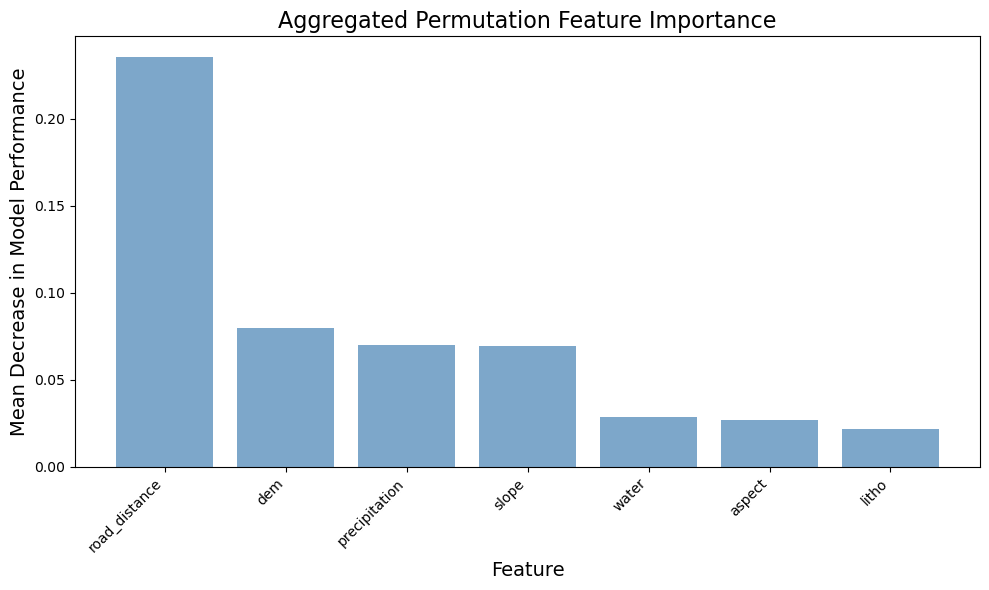

In [20]:
# plot aggregated permutation feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"], color="steelblue", alpha=0.7)
plt.xticks(rotation=45, ha="right")
plt.title("Aggregated Permutation Feature Importance", fontsize=16)
plt.xlabel("Feature", fontsize=14)
plt.ylabel("Mean Decrease in Model Performance", fontsize=14)
plt.tight_layout()
plt.show()

## Predict Landslide Susceptibility for full Viewmask

In [21]:
# prediction for whole area within the viewmask
stacked_data = np.stack(
    [rasters[key] for key in rasters.keys()],
    axis=-1
)

# create mask to only use valid features (pixel)
valid_mask = np.all(stacked_data != -9999, axis=-1)
stacked_data_flat = stacked_data[valid_mask]

# extract ordinal/nominal indices for data within viewmask
continuous_indices = [list(rasters.keys()).index(var) for var in continuous_vars]
ordinal_indices = [list(rasters.keys()).index(var) for var in ordinal_vars]
nominal_indices = [list(rasters.keys()).index(var) for var in nominal_vars]

# extract continuous, ordinal and nominal variables
stacked_data_continuous = stacked_data_flat[..., continuous_indices]
stacked_data_ordinal = stacked_data_flat[..., ordinal_indices]
stacked_data_nominal = stacked_data_flat[..., nominal_indices]

# encode variables
stacked_data_ordinal_encoded = ordinal_encoder.transform(stacked_data_ordinal.reshape(-1, len(ordinal_vars)))
stacked_data_nominal_encoded = onehot_encoder.transform(stacked_data_nominal.reshape(-1, len(nominal_vars)))

# combine encoded variables
stacked_data_encoded = np.hstack([stacked_data_continuous, stacked_data_ordinal_encoded, stacked_data_nominal_encoded])

# predict probabilities
predictions = model_optimized.predict_proba(stacked_data_encoded)[:, 1]

# create empty hazard map
hazard_map = np.full(valid_mask.shape, np.nan, dtype=np.float32)

# fill hazard map with predictions
hazard_map[valid_mask] = predictions

# define output path
out_path = "created/predictions/RF_landslide_susceptibility_map_viewshed.tif"

# write hazard map to GeoTIFF
with rasterio.open(
    out_path,
    "w",
    driver="GTiff",
    height=hazard_map.shape[0],
    width=hazard_map.shape[1],
    count=1,
    dtype=hazard_map.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(hazard_map, 1)

print(f"Hazard map for viewmask saved at: <{out_path}>.")

Hazard map for viewmask saved at: <created/predictions/RF_landslide_susceptibility_map_viewshed.tif>.


## Predict Landslide Susceptibility for full Study Area

In [22]:
# extract raster dimensions (assuming all rasters have the same shape)
raster_shape = next(iter(rasters_mixed.values())).shape
height, width = raster_shape

# define hazard map out path
output_path = "created/predictions/RF_landslide_susceptibility_map.tif"

# set chunk size (512x512 pixel) to predict and write susceptibility chunk wise
chunk_size = 512

# extract continuous/ordinal/nominal indices (based on unmasked rasters_mixed data)
continuous_indices = [list(rasters_mixed.keys()).index(var) for var in continuous_vars]
ordinal_indices = [list(rasters_mixed.keys()).index(var) for var in ordinal_vars]
nominal_indices = [list(rasters_mixed.keys()).index(var) for var in nominal_vars]

# define meta data for resulting GeoTIFF
meta = {
    "driver": "GTiff",
    "height": height,
    "width": width,
    "count": 1,
    "dtype": "float32",
    "crs": crs,
    "transform": transform,
}

# create empty output file
with rasterio.open(output_path, "w", **meta) as dst:
    # iterate through raster chunks
    for y in range(0, height, chunk_size):
        for x in range(0, width, chunk_size):
            # get size of current chunk
            y_end = min(y + chunk_size, height)
            x_end = min(x + chunk_size, width)
            
            # stack all input variables for current chunk
            stacked_chunk = np.stack(
                [array[y:y_end, x:x_end] for array in rasters_mixed.values()],
                axis=-1,
            )
            
            # define valid mask for current chunk
            valid_mask_chunk = np.all(stacked_chunk != -9999, axis=-1)
            
            # create empty hazard map for current chunk (default to -9999)
            # hazard_chunk = np.full((y_end - y, x_end - x), -9999, dtype=np.float32)
            hazard_chunk = np.full((y_end - y, x_end - x), np.nan, dtype=np.float32)
            
            # process valid data if existing
            if np.any(valid_mask_chunk):
                # flatten chunk data
                stacked_chunk_flat = stacked_chunk[valid_mask_chunk]
                
                # extract continuous/ordinal/nominal variables in chunk
                stacked_chunk_continuous = stacked_chunk_flat[..., continuous_indices]
                stacked_chunk_ordinal = stacked_chunk_flat[..., ordinal_indices]
                stacked_chunk_nominal = stacked_chunk_flat[..., nominal_indices]
                
                # apply encoder
                stacked_chunk_ordinal_encoded = ordinal_encoder.transform(stacked_chunk_ordinal)
                stacked_chunk_nominal_encoded = onehot_encoder.transform(stacked_chunk_nominal)
                
                # combine encoded data
                stacked_chunk_encoded = np.hstack([stacked_chunk_continuous, stacked_chunk_ordinal_encoded, stacked_chunk_nominal_encoded])
                
                # predict for current chunk
                predictions_chunk = model_optimized.predict_proba(stacked_chunk_encoded)[:, 1]
                
                # fill predictions into the hazard map
                hazard_chunk[valid_mask_chunk] = predictions_chunk
            
            # write current chunk to output GeoTIFF
            dst.write(hazard_chunk, 1, window=Window(x, y, x_end - x, y_end - y))

print(f"Hazard map for full study area saved at: <{output_path}>.")




Hazard map for full study area saved at: <created/predictions/RF_landslide_susceptibility_map.tif>.


## Classify Landslide Susceptibility Map for full Study Area

In [23]:
# define output path
output_path_classified = "created/predictions/RF_landslide_susceptibility_map_classified.tif"

# open GeoTIFF
with rasterio.open(output_path) as src:
    rf_result = src.read(1)

# set no data values to nan
rf_result = np.where(rf_result == src.nodata, np.nan, rf_result)

# classify RF result
rf_result_classified = classify_lsm(rf_result, 0.0, 1.0)

# write classified RF result to GeoTIFF
with rasterio.open(
    output_path_classified,
    "w",
    driver="GTiff",
    height=rf_result_classified.shape[0],
    width=rf_result_classified.shape[1],
    count=1,
    dtype=rf_result_classified.dtype,
    crs=src.crs,
    transform=src.transform
) as dst:
    dst.write(rf_result_classified, 1)